In [ ]:
# In root/notebooks/fulltrain_analysis.ipynb

from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re
import torch
from torch.utils.data import DataLoader
import yaml

PROJECT_ROOT = Path("..").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src.data.dataloader import ForgeryDataset, get_val_transform
from src.models.mask2former_v2 import Mask2FormerForgeryModel
from src.utils.config_utils import sanitize_model_kwargs

In [2]:
# Constants
BASE = Path("../experiments/cls_collapse")
RUN_25 = "full_full_cls_w0.25"
RUN_5  = "full_full_cls_w0.25"   # (optional) 

In [3]:
# Load run
def read_json(p: Path):
    return json.loads(p.read_text()) if p.exists() else {}

def read_csv(p: Path):
    return pd.read_csv(p) if p.exists() else pd.DataFrame()

def read_jsonl(p: Path):
    if not p.exists():
        return pd.DataFrame()
    rows = []
    for line in p.read_text().splitlines():
        line = line.strip()
        if line:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

def load_run(run_name: str):
    d = BASE / run_name
    return {
        "name": run_name,
        "dir": d,
        "meta": read_json(d / "meta.json"),
        "opt": read_json(d / "optimizer.json"),
        "steps": read_csv(d / "step_losses.csv"),
        "epochs": read_csv(d / "epoch_summary.csv"),
        "dbg": read_jsonl(d / "debug.jsonl"),
    }

run = load_run(RUN_25)
run["dir"], run["steps"].shape, run["epochs"].shape

(WindowsPath('../experiments/cls_collapse/full_full_cls_w0.25'),
 (38820, 14),
 (30, 10))

In [4]:
# Final-epoch summary + quick collapse flags (expanded but still simple)

def _last_row(df, sort_col=None):
    if df is None or len(df) == 0:
        return {}
    d = df.copy()
    if sort_col is not None and sort_col in d.columns:
        d = d.sort_values(sort_col)
    return d.iloc[-1].to_dict()

def _get_last_debug_payload(dbg_df, tag):
    if dbg_df is None or len(dbg_df) == 0 or "tag" not in dbg_df.columns:
        return {}
    d = dbg_df[dbg_df["tag"] == tag].copy()
    if len(d) == 0:
        return {}
    # prefer "global_step"/"epoch" ordering if present
    for c in ["global_step", "epoch", "step", "ts"]:
        if c in d.columns:
            d = d.sort_values(c)
    return d.iloc[-1].to_dict()

epochs = run["epochs"].copy()
last = _last_row(epochs, sort_col="epoch")

dbg = run["dbg"].copy()
dbg_last_oof = _get_last_debug_payload(dbg, "oof_inference_debug")
dbg_last_auth_pen = _get_last_debug_payload(dbg, "loss_auth_penalty_stats")
dbg_last_presence = _get_last_debug_payload(dbg, "loss_presence_stats")
dbg_last_cls_tgt = _get_last_debug_payload(dbg, "loss_cls_targets")

summary = {
    "run": run["name"],

    # epoch-level
    "epoch_last": last.get("epoch"),
    "epoch_loss_last": last.get("epoch_loss") or last.get("train_epoch_loss") or last.get("loss"),
    "cls_max_mean_last": last.get("cls_max_mean"),
    "cls_max_p95_last": last.get("cls_max_p95"),
    "mask_max_mean_last": last.get("mask_max_mean"),
    "mask_max_p95_last": last.get("mask_max_p95"),
    "img_forged_mean_last": last.get("img_forged_mean"),
    "img_forged_p95_last": last.get("img_forged_p95"),

    # keep-rates (if logged)
    "keep_rate@0.1_last": last.get("keep_rate@0.1"),
    "keep_rate@0.2_last": last.get("keep_rate@0.2"),
    "keep_rate@0.3_last": last.get("keep_rate@0.3"),

    # loss weights (if logged)
    "w_mask_cls_last": last.get("w_mask_cls"),
    "w_auth_penalty_last": last.get("w_auth_penalty") or last.get("w_auth_penalty_weight"),

    # last seen training-side debug (if present)
    "auth_penalty_thr_last": dbg_last_auth_pen.get("thr"),
    "auth_penalty_temp_last": dbg_last_auth_pen.get("temp"),
    "loss_auth_penalty_last": dbg_last_auth_pen.get("loss_auth_penalty"),
    "presence_mean_last": dbg_last_presence.get("presence_mean"),
    "presence_min_last": dbg_last_presence.get("presence_min"),
    "presence_max_last": dbg_last_presence.get("presence_max"),
    "presence_tau_last": dbg_last_presence.get("tau"),
    "loss_presence_auth_last": dbg_last_presence.get("loss_presence_auth"),
    "loss_forged_presence_last": dbg_last_presence.get("loss_forged_presence"),
    "cls_target_pos_frac_last": dbg_last_cls_tgt.get("pos_frac"),

    # last seen inference-side debug (if present)
    "oof_masks_empty_rate": (dbg_last_oof.get("rates") or {}).get("masks_empty") if isinstance(dbg_last_oof.get("rates"), dict) else None,
    "oof_num_keep0_rate": (dbg_last_oof.get("rates") or {}).get("num_keep0") if isinstance(dbg_last_oof.get("rates"), dict) else None,
    "oof_no_fg_pre_keep_rate": (dbg_last_oof.get("rates") or {}).get("no_fg_pre_keep") if isinstance(dbg_last_oof.get("rates"), dict) else None,
}

flags = {
    "cls_collapsed@~0.125": (summary["cls_max_mean_last"] is not None) and abs(summary["cls_max_mean_last"] - 0.125) < 1e-3,
    "mask_saturated@>0.99": (summary["mask_max_mean_last"] is not None) and summary["mask_max_mean_last"] > 0.99,

    # extra “quick reads”
    "predicts_all_auth@oof": (summary["oof_masks_empty_rate"] is not None) and (summary["oof_masks_empty_rate"] > 0.99),
    "cls_filters_everything@oof": (summary["oof_num_keep0_rate"] is not None) and (summary["oof_num_keep0_rate"] > 0.99),
    "mask_head_dead@oof": (summary["oof_no_fg_pre_keep_rate"] is not None) and (summary["oof_no_fg_pre_keep_rate"] > 0.99),
}

summary, flags


({'run': 'full_full_cls_w0.25',
  'epoch_last': 25.0,
  'epoch_loss_last': 1.5176893376516412,
  'cls_max_mean_last': 0.1526786535978317,
  'cls_max_p95_last': 0.1634342968463897,
  'mask_max_mean_last': 0.9999645948410034,
  'mask_max_p95_last': None,
  'img_forged_mean_last': 0.5068926811218262,
  'img_forged_p95_last': None,
  'keep_rate@0.1_last': 0.5833333730697632,
  'keep_rate@0.2_last': 0.0,
  'keep_rate@0.3_last': 0.0,
  'w_mask_cls_last': 1.0,
  'w_auth_penalty_last': None,
  'auth_penalty_thr_last': 0.5,
  'auth_penalty_temp_last': 0.1,
  'loss_auth_penalty_last': 3.3088557935267993e-12,
  'presence_mean_last': None,
  'presence_min_last': None,
  'presence_max_last': None,
  'presence_tau_last': None,
  'loss_presence_auth_last': None,
  'loss_forged_presence_last': None,
  'cls_target_pos_frac_last': 0.08333333333333333,
  'oof_masks_empty_rate': None,
  'oof_num_keep0_rate': None,
  'oof_no_fg_pre_keep_rate': None},
 {'cls_collapsed@~0.125': False,
  'mask_saturated@>0.99

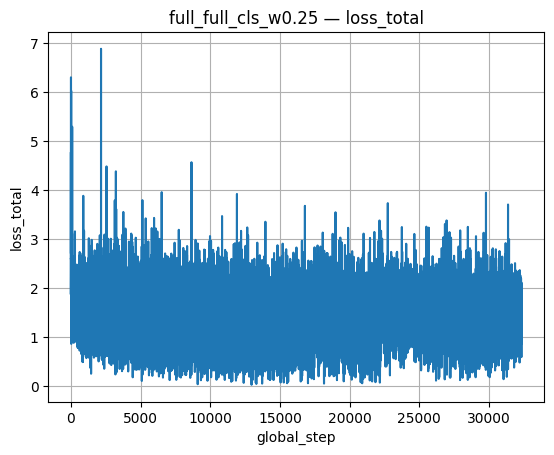

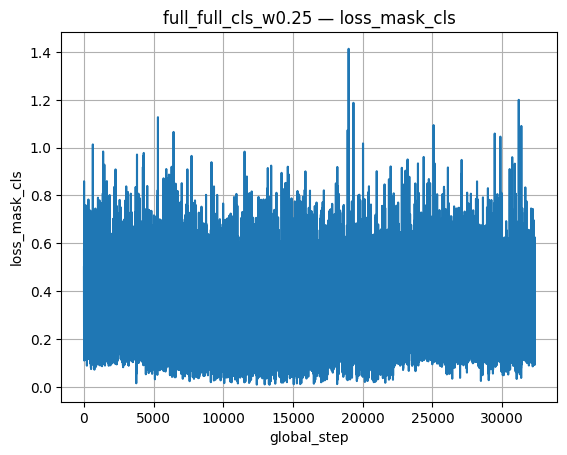

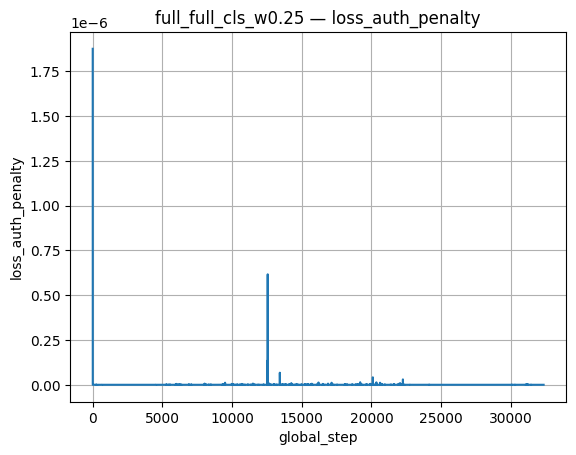

In [5]:
# Learning curves (step-level)
steps = run["steps"].copy()
steps = steps.sort_values("global_step") if "global_step" in steps.columns else steps

def plot_step(metric):
    if metric not in steps.columns or "global_step" not in steps.columns:
        print(f"missing {metric} or global_step in step_losses.csv")
        return
    plt.figure()
    plt.plot(steps["global_step"], steps[metric])
    plt.xlabel("global_step")
    plt.ylabel(metric)
    plt.title(f"{run['name']} — {metric}")
    plt.grid(True)
    plt.show()

for m in ["loss_total", "loss_mask_cls", "loss_auth_penalty"]:
    plot_step(m)

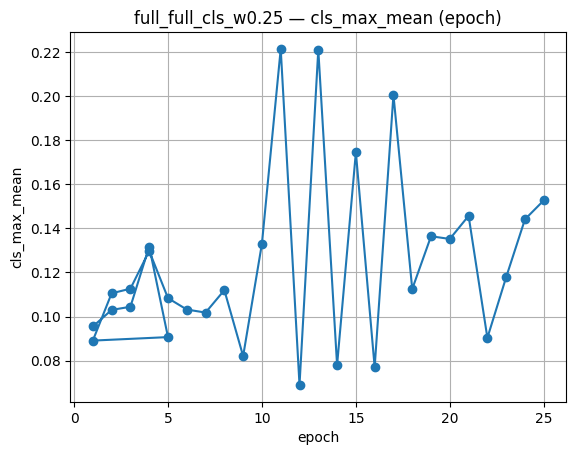

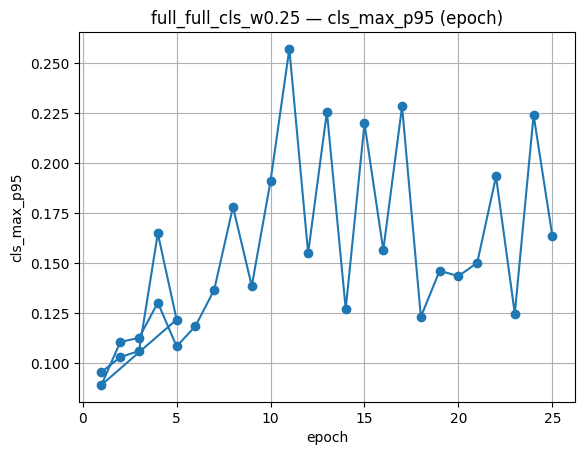

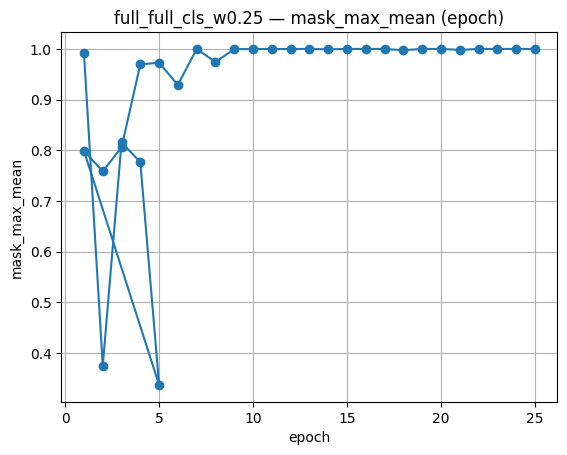

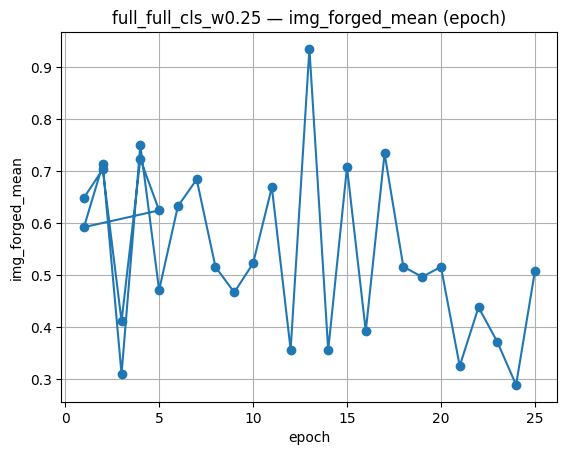

In [6]:
# Epoch curves (collapse indicators over time)
def plot_epoch(metric):
    if metric not in epochs.columns or "epoch" not in epochs.columns:
        print(f"missing {metric} or epoch in epoch_summary.csv")
        return
    plt.figure()
    plt.plot(epochs["epoch"], epochs[metric], marker="o")
    plt.xlabel("epoch")
    plt.ylabel(metric)
    plt.title(f"{run['name']} — {metric} (epoch)")
    plt.grid(True)
    plt.show()

for m in ["cls_max_mean", "cls_max_p95", "mask_max_mean", "img_forged_mean"]:
    plot_epoch(m)


In [8]:
# Debug JSONL: cls target density + auth penalty stats (if present)
dbg = run["dbg"].copy()


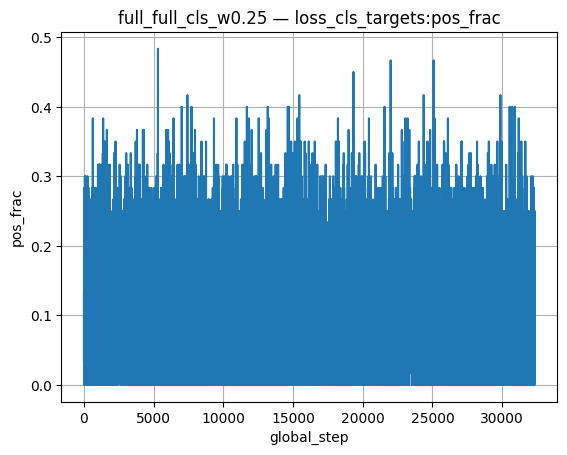

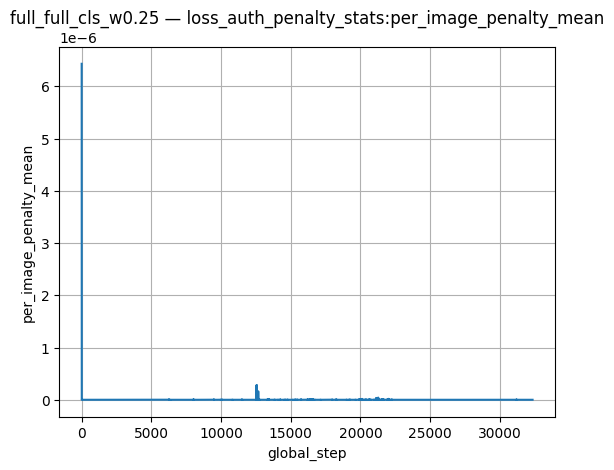

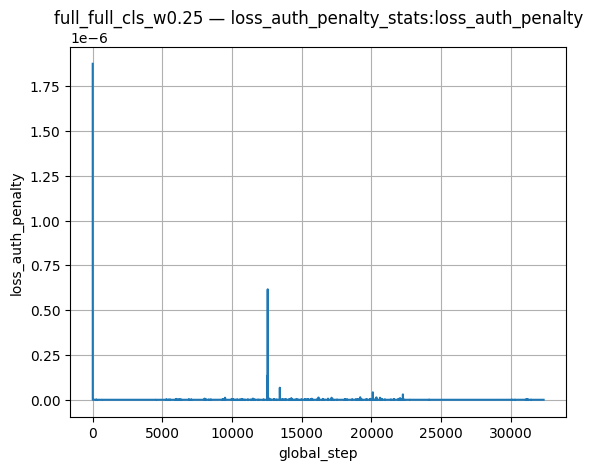

In [9]:
def plot_dbg(tag, y):
    if dbg.empty or "tag" not in dbg.columns:
        print("no debug.jsonl")
        return
    sub = dbg[dbg["tag"] == tag].copy()
    if sub.empty or y not in sub.columns:
        print(f"no rows for tag={tag} with field={y}")
        return
    x = "global_step" if "global_step" in sub.columns else None
    if x is None:
        print("no global_step in debug.jsonl records")
        return
    sub = sub.sort_values(x)
    plt.figure()
    plt.plot(sub[x], sub[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{run['name']} — {tag}:{y}")
    plt.grid(True)
    plt.show()

plot_dbg("loss_cls_targets", "pos_frac")
plot_dbg("loss_auth_penalty_stats", "per_image_penalty_mean")
plot_dbg("loss_auth_penalty_stats", "loss_auth_penalty")


In [ ]:
# (Optional) compare your new 25-epoch run to an older run (set RUN_5 to the old run folder name)
if RUN_5 != RUN_25:
    run_old = load_run(RUN_5)
    e_new = run["epochs"].sort_values("epoch")
    e_old = run_old["epochs"].sort_values("epoch")

    def compare_epoch(metric):
        if metric not in e_new.columns or metric not in e_old.columns:
            print("missing", metric)
            return
        plt.figure()
        plt.plot(e_old["epoch"], e_old[metric], marker="o", label=f"{RUN_5}")
        plt.plot(e_new["epoch"], e_new[metric], marker="o", label=f"{RUN_25}")
        plt.xlabel("epoch"); plt.ylabel(metric)
        plt.title(metric)
        plt.grid(True)
        plt.legend()
        plt.show()

    for m in ["cls_max_mean", "mask_max_mean", "img_forged_mean"]:
        compare_epoch(m)
